In [14]:
# Required Python Machine learning Packages
import pandas as pd
import numpy as np

# To split the dataset into train and test datasets
from sklearn.model_selection import train_test_split

# To model the Gaussian Navie Bayes classifier
from sklearn.naive_bayes import GaussianNB

# To calculate the accuracy score of the model
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from datetime import datetime

from scipy import stats

from pyod.models.abod import ABOD
from pyod.models.knn import KNN

# The Data

The Data was downloaded from kaggle. It is data collected from a clinic in Brazil. The data includes relevant patient information and whether or not they showed up to their scheduled appointment. It includes 110527 patient rows.

The following columns 'Gender,'Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', and 'no-show' are categorical variables. 

We begin by outcome into a binary format. 0 = Show. 1 = No-Show.

We check for null data, for which there is none anyway. 

The collowing columns are irrelevant to our model and are removed: 'PatientId', 'AppointmentID.' 

Some columns are misspelled and we rename our columns with right spelling. Scholarship = Welfare (goverment healthcare assistance/coverage). 


In [15]:
df = pd.read_csv('noshow.csv')

print(df.shape)
print(list(df.columns))

(110527, 14)
['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay', 'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'No-show']


In [16]:
no_show = df['No-show'].tolist()

for i in range (len(no_show)):
    if no_show[i] == "Yes":
        no_show[i] = 1
    else: 
        no_show[i] = 0

df["No-show"] = no_show

df = df[['Gender', 'ScheduledDay', 'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'No-show']]

colnames = ['Gender', 'ScheduledDay', 'AppointmentDay', 'Age', 'Neighbourhood', 'Welfare', 'Hypertension', 'Diabetes', 'Alcoholism', 'Handicap', 'SMS_received', 'No-show']

df.columns = colnames

In [17]:
df[['No-Show']].plot.bar()

KeyError: "None of [Index(['No-Show'], dtype='object')] are in the [columns]"

In [18]:
df.isnull().sum()

Gender            0
ScheduledDay      0
AppointmentDay    0
Age               0
Neighbourhood     0
Welfare           0
Hypertension      0
Diabetes          0
Alcoholism        0
Handicap          0
SMS_received      0
No-show           0
dtype: int64

### Creating New Vars
We begin with creation of a new varaible which uses the two columns ScheduledDay and AppointmentDay to generate a DaysBetween variable which tells us how many days were in between the scheduled day of appointment and the actual appointment day. 

In [19]:
sd = df['ScheduledDay'].tolist()
ad = df['AppointmentDay'].tolist()
days = []

def days_between(d1, d2):
    d1 = datetime.strptime(d1, '%Y-%m-%d')
    d2 = datetime.strptime(d2, '%Y-%m-%d')
    days.append((d2 - d1).days)
    
for i in range (len(sd)):
    sd[i] = sd[i].split('T')[0]
    ad[i] = ad[i].split('T')[0]
    days_between(sd[i], ad[i])
    
df['DaysBetween'] = days

### Data Cleaning

In [20]:
df = df [['Gender', 'Age', 'Neighbourhood', 'Welfare', 'Hypertension', 'Diabetes', 'Alcoholism', 'Handicap', 'SMS_received', 'DaysBetween','No-show']]

df.head()

,Gender,Age,Neighbourhood,Welfare,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,DaysBetween,No-show
0,F,62,JARDIM DA PENHA,0,1,0,0,0,0,0,0
1,M,56,JARDIM DA PENHA,0,0,0,0,0,0,0,0
2,F,62,MATA DA PRAIA,0,0,0,0,0,0,0,0
3,F,8,PONTAL DE CAMBURI,0,0,0,0,0,0,0,0
4,F,56,JARDIM DA PENHA,0,1,1,0,0,0,0,0


Removing all values with a sub-zero days between as this represents an input error in the data

In [21]:
df = df.query('DaysBetween >= 0')

### Data Transforming

2.665895975880355

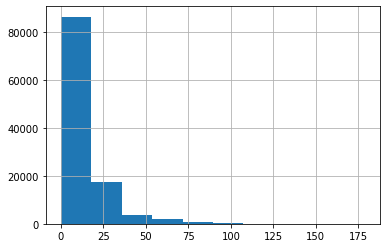

In [22]:
df["DaysBetween"].hist()
df["DaysBetween"].skew()

0.22764848088747605

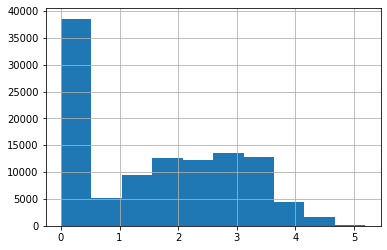

In [23]:
df['DaysBetweenLog'] = np.log(1 + df['DaysBetween'])

df["DaysBetweenLog"].hist()

df["DaysBetweenLog"].skew()

### Log works

going to bucketize DaysBetween

In [9]:
bins = [0, 1, 2, 5, 10, 22, 60, 179]
labels = []

for i in range (len(bins)-1):
    string =  str(bins[i]) + "to" + str(bins[i+1])
    labels.append(string)

df['DaysBetweenBinned'] = pd.cut(df['DaysBetween'], bins, labels = labels, include_lowest=True, right = False)

### Normalization ?

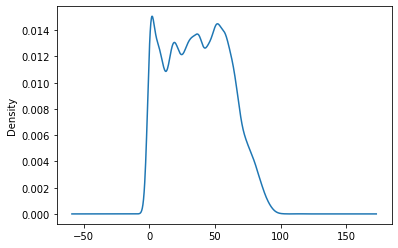

In [10]:
df['Age'].plot.kde()

Age distribution appears to be normal

# Data Exploration

In [11]:
df['No-show'].value_counts()

0    88208
1    22314
Name: No-show, dtype: int64

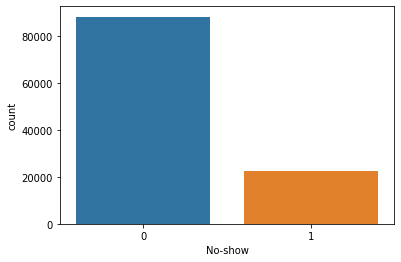

In [12]:
sns.countplot(x='No-show',data=df)

plt.show()

Outcome values are imbalanced.

In [13]:
df.groupby('No-show').mean()

,Age,Welfare,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,DaysBetween,DaysBetweenLog
No-show,,,,,,,,,
0,37.790064,0.093903,0.204392,0.073837,0.030417,0.022742,0.291334,8.754659,1.353204
1,34.317872,0.115533,0.169042,0.064085,0.030340,0.020212,0.438469,15.835484,2.302603


### Out-come correlations at first sight

 - No-Shows tend to be younger, recieved SMS messages less frequently, and had more days between their appointment day and day scheduled. 

 - This points to a curious conclusion: SMS messages are contributing to more no-shows. 

 - Since we have no information regarding the method of how the SMS was sent, the frequency of SMS messaging. We find this variable to be quite conflicting and possibly damaging to obtaining true model. Perhaps those who are older don't get SMS's because of a lack of a phone...

### Understanding SMS_Received

Those who recieve SMS's actually tended to be older, so this disproves our ideas in co-linearity between age and SMS_received. However an interesting aspect here is the significant difference in mean DaysBetween between sms receieved and not.

In [14]:
df.groupby('SMS_received').mean()

,Age,Welfare,Hypertension,Diabetes,Alcoholism,Handicap,DaysBetween,No-show,DaysBetweenLog
SMS_received,,,,,,,,,
0,36.888193,0.098028,0.198974,0.074454,0.033489,0.024907,6.007902,0.166978,1.000353
1,37.513810,0.098782,0.193619,0.066400,0.023871,0.016572,19.016713,0.275745,2.696501


### So... is SMS messaging working?

We're going to look into one Days Between bin (2 to 5) and see if there is a difference between the subgroups who received messages and who did not. 

In [15]:
twofivebin = df.loc[df['DaysBetweenBinned'] == '2to5']

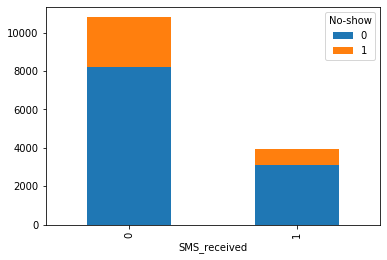

In [16]:
%matplotlib inline
pd.crosstab(twofivebin.SMS_received,twofivebin['No-show']).plot(kind='bar', stacked = True)

In [17]:
twofivebin.groupby('SMS_received').mean()

,Age,Welfare,Hypertension,Diabetes,Alcoholism,Handicap,DaysBetween,No-show,DaysBetweenLog
SMS_received,,,,,,,,,
0,44.579318,0.078855,0.280115,0.109989,0.028076,0.027984,2.584044,0.240734,1.253259
1,42.418939,0.096212,0.271212,0.100758,0.029293,0.022980,3.771212,0.221970,1.558385


Maybe? There does seems to be a slight correlation, but maybe there are confounding variables. Still, we'll leave it in the model

### Looking into Hypertension

In [18]:
df.groupby('Hypertension').mean()

,Age,Welfare,Diabetes,Alcoholism,Handicap,SMS_received,DaysBetween,No-show,DaysBetweenLog
Hypertension,,,,,,,,,
0,31.308461,0.101182,0.016422,0.022915,0.015814,0.322494,10.314570,0.208992,1.550428
1,60.613596,0.086418,0.297509,0.060869,0.048346,0.315123,9.653915,0.173020,1.522323


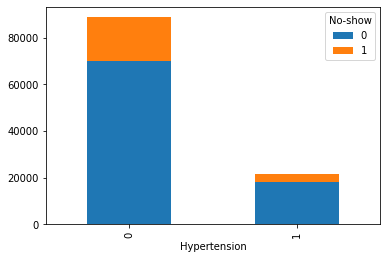

In [19]:
pd.crosstab(df.Hypertension,df['No-show']).plot(kind='bar', stacked = True)

Slight Correlation, we'll keep in our model. 

In [25]:
df.columns

indcols = ['Gender', 'Age', 'Neighbourhood', 'Welfare', 'Hypertension', 'Diabetes',
       'Alcoholism', 'Handicap', 'SMS_received', 'DaysBetweenLog']

targcols = ['No-show']

### Chi_Square Test

For loop will run a chi-square test on all binary feaatures.

In [26]:
df_str = df.copy()

In [30]:
string_columns = [col for col in df_str.columns if col not in ['Age', 'DaysBetween', 'DaysBetweenLog', 'No-show']]
for col in string_columns:
    df_str[col] = df_str[col].astype(str)

dropfeatures = []

print("Chi Square Scores \n")
for col in string_columns:
    crosstab = pd.crosstab(df[col], df['No-show'])
    crosstab
    chi_sqr = stats.chi2_contingency(crosstab)
    print(col + " {0:.2f}".format(chi_sqr[0]) + " P-value: {0:.2f}".format(chi_sqr[1]))
    if chi_sqr[1] > 0.05:
        dropfeatures.append(col)
        
print("\nThe following features have p-values below 0.05 and should be looked out for: " + str(dropfeatures))

Chi Square Scores 

Gender 1.86 P-value: 0.17
Neighbourhood 492.99 P-value: 0.00
Welfare 93.78 P-value: 0.00
Hypertension 140.32 P-value: 0.00
Diabetes 25.24 P-value: 0.00
Alcoholism 0.00 P-value: 0.97
Handicap 7.49 P-value: 0.11
SMS_received 1768.07 P-value: 0.00

The following features have p-values below 0.05 and should be looked out for: ['Gender', 'Alcoholism', 'Handicap']


#### Going to remove Alcoholism as a feature as it Chi_square score is exteremely low. 

### Looking for extreme dependence between features

In [23]:
for col in string_columns:
    for col2 in string_columns:
        if col == col2:
            break
        else:
            crosstab = pd.crosstab(df[col], df[col2])
            chi_sqr = stats.chi2_contingency(crosstab)
            if chi_sqr[0] > 5000:
                print(col + " and  " + col2 +" "+str(chi_sqr[0]))

Welfare and  Neighbourhood 5421.681960196618
Diabetes and  Hypertension 20725.34890744044
DaysBetweenBinned and  Neighbourhood 21846.657110267675
DaysBetweenBinned and  SMS_received 40386.605341119845


### Chi-Square Results

The above following are correlated to each other, but, independently they are all good indicators of our target results. So we can keep them.

We drop alcoholism because its Chi_Square is ridiculously small. 

The other two variables with that 'fail to reject the null hypothesis assuming alhpa = 0.05' are Gender and Handicap. 
However, these features don't prove to be co-linear (or co-correlated with our other fearures) and so can not neccesarily hurt out models.

In [32]:
dropfeatures = ['Alcoholism']

In [33]:
c = df.corr().abs()
s = c.unstack(level=1)
so = s.sort_values(kind="quicksort", ascending=False)

so[80:]

Diabetes        No-show           0.015156
No-show         Diabetes          0.015156
SMS_received    Diabetes          0.014559
Diabetes        SMS_received      0.014559
Age             SMS_received      0.012639
SMS_received    Age               0.012639
Handicap        Welfare           0.008554
Welfare         Handicap          0.008554
Hypertension    DaysBetweenLog    0.008144
DaysBetweenLog  Hypertension      0.008144
Handicap        No-show           0.006289
No-show         Handicap          0.006289
Hypertension    SMS_received      0.006282
SMS_received    Hypertension      0.006282
Alcoholism      Handicap          0.004668
Handicap        Alcoholism        0.004668
Welfare         SMS_received      0.001184
SMS_received    Welfare           0.001184
Alcoholism      No-show           0.000180
No-show         Alcoholism        0.000180
dtype: float64

Again. Alcoholism is not good for our model. 

### Dropping unwanted features

In [34]:
dropfeatures.append('DaysBetween')
dropfeatures.append("DaysBetweenBinned")
#df = df.drop((col for col in dropfeatures if col != "Alcoholism"), axis = 1)
df = df.drop(dropfeatures, axis = 1)

In [35]:
df.head()

,Gender,Age,Neighbourhood,Welfare,Hypertension,Diabetes,Handicap,SMS_received,No-show,DaysBetweenLog
0,F,62,JARDIM DA PENHA,0,1,0,0,0,0,0.0
1,M,56,JARDIM DA PENHA,0,0,0,0,0,0,0.0
2,F,62,MATA DA PRAIA,0,0,0,0,0,0,0.0
3,F,8,PONTAL DE CAMBURI,0,0,0,0,0,0,0.0
4,F,56,JARDIM DA PENHA,0,1,1,0,0,0,0.0


# Machine Learning Set-Up

In [61]:
def label_encode(df, columns):
    for col in columns:
        le = LabelEncoder()
        col_values_unique = list(df[col].unique())
        le_fitted = le.fit(col_values_unique)
        col_values = list(df[col].values)
        col_values_transformed = le.transform(col_values)
        df[col] = col_values_transformed

In [62]:
features = df.drop(['Age', 'DaysBetweenLog', 'No-show'], axis = 1)

label_encode(features, features.columns.values)

features['Age'] = df['Age']
features['DaysBetweenLog'] = df['DaysBetweenLog']

target = df[['No-show']]

label_encode(target, target.columns.values)

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size = 0.20, random_state = 10)

features.head()

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Gender,Neighbourhood,Welfare,Hypertension,Diabetes,Handicap,SMS_received,Age,DaysBetweenLog
0,0,39,0,1,0,0,0,62,0.0
1,1,39,0,0,0,0,0,56,0.0
2,0,45,0,0,0,0,0,62,0.0
3,0,54,0,0,0,0,0,8,0.0
4,0,39,0,1,1,0,0,56,0.0


# Feature Importance 

In [94]:
from sklearn.ensemble import ExtraTreesClassifier

modelFI = ExtraTreesClassifier()
modelFI.fit(features, target)

importance = modelFI.feature_importances_
feat_importance = []

for i in range (len(features.columns)):
    feat_importance.append([importance[i],features.columns[i]])
    
feat_importance.sort(reverse=True)

print("3 most importance features: " + str(feat_importance[:3]))

//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


3 most importance features: [[0.33631228017485804, 'Age'], [0.33112854973881445, 'Neighbourhood'], [0.29225292469891884, 'DaysBetweenLog']]


In [43]:
def crossvalidation (x, y, model):
    from sklearn.model_selection import KFold # import KFold
    from sklearn.model_selection import cross_val_score, cross_val_predict
    y = y.values.ravel()
    model.fit(x, y)
    kf = KFold(n_splits=10,random_state=2, shuffle=False)
    scores = cross_val_score(model, x, y, cv=kf)
    print('Cross-validated scores:', scores.mean())

In [44]:
#Training the model with KNN
from sklearn.neighbors import KNeighborsClassifier
modelKNN = KNeighborsClassifier(n_neighbors=10)
modelKNN.fit(features_train, target_train)
y_pred = modelKNN.predict(features_test)
y_pred

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  after removing the cwd from sys.path.


array([0, 0, 0, ..., 0, 0, 0])

Accuracy Score  = 0.791449898213074
Cross-validated scores: 0.7893269642248504
AUC Score: 0.8207537280650633


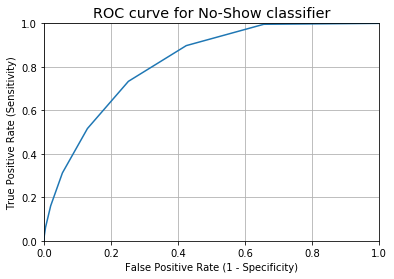

In [45]:
#testing the model with KNN
import matplotlib.pyplot as plt
from sklearn import metrics

print("Accuracy Score  = " + str(metrics.accuracy_score(target_test, y_pred)))

crossvalidation(features, target, modelKNN)

y_pred_prob = modelKNN.predict_proba(features_test)[:, 1]

fpr, tpr, thresholds = metrics.roc_curve(target_test, y_pred_prob)

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for No-Show classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)
print("AUC Score: " + str(metrics.roc_auc_score(target_test, y_pred_prob)))

In [46]:
modelNB = GaussianNB()
modelNB.fit(features_train, target_train.values.ravel())
target_pred = modelNB.predict(features_test)
target_pred

array([0, 1, 0, ..., 0, 0, 0])

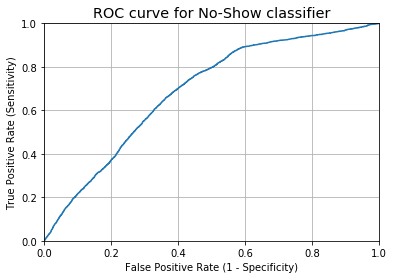

In [47]:
%matplotlib inline
import matplotlib.pyplot as plt

# IMPORTANT: first argument is true values, second argument is predicted probabilities

# we pass y_test and y_pred_prob

target_pred_prob = modelNB.predict_proba(features_test)[:, 1]

# we do not use y_pred_class, because it will give incorrect results without generating an error
# roc_curve returns 3 objects fpr, tpr, thresholds
# fpr: false positive rate
# tpr: true positive rate
fpr, tpr, thresholds = metrics.roc_curve(target_test, target_pred_prob)

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for No-Show classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [48]:
print("Naive Bayes")
print("Accuracy Score  = " + str(metrics.accuracy_score(target_test, target_pred)))
crossvalidation(features, target, modelNB)
print("ROC SCORE: " + str(metrics.roc_auc_score(target_test, target_pred_prob)))

Naive Bayes
Accuracy Score  = 0.7626328884867677
Cross-validated scores: 0.759169882753904
ROC SCORE: 0.6884977054024563


In [49]:
from sklearn.ensemble import RandomForestClassifier


# instantiate model
modelRFC = RandomForestClassifier(random_state=1, max_depth=10)

# fit model
modelRFC.fit(features_train, target_train.values.ravel())

y_pred = modelRFC.predict(features_test)
y_pred

//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


array([0, 0, 0, ..., 0, 0, 0])

Accuracy Score = 0.7967880570006786
Cross-validated scores: 0.797768727840744
ROC Score: 0.7630722264892305


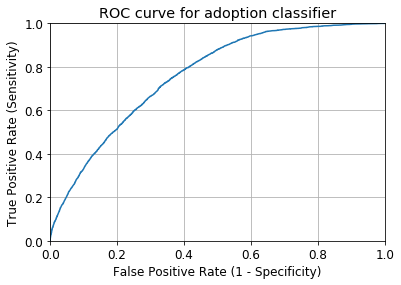

In [50]:
print("Accuracy Score = " + str(metrics.accuracy_score(target_test, y_pred)))

crossvalidation(features, target, modelRFC)

y_pred_prob = modelRFC.predict_proba(features_test)[:, 1]

fpr, tpr, thresholds = metrics.roc_curve(target_test, y_pred_prob)

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for adoption classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

print("ROC Score: "+ str(metrics.roc_auc_score(target_test, y_pred_prob)))

### Recursive Feature Elimination

In [51]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()

rfe = RFE(logreg, 20)
rfe = rfe.fit(features_train, target_train.values.ravel())

print(rfe.support_)
print(rfe.ranking_)

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[ True  True  True  True  True  True  True  True  True]
[1 1 1 1 1 1 1 1 1]


#### All Features are valuable in improving accuracy of model. 

# Logistical Regression

In [95]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

modelLR = LogisticRegression()
modelLR.fit(features_train, target_train.values.ravel())

y_pred = modelLR.predict(features_test)
y_pred

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


array([0, 0, 0, ..., 0, 0, 0])

In [96]:
print('Accuracy of logistic regression classifier on test set: {:f}'.format(modelLR.score(features_test, target_test)))

crossvalidation(features, target, modelLR)

Accuracy of logistic regression classifier on test set: 0.795250


//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  

Cross-validated scores: 0.7969272479104805


ROC Score: 0.7109489719470363


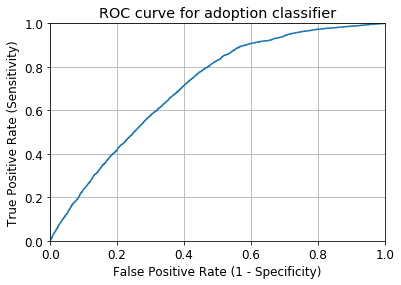

In [97]:
y_pred_prob = modelLR.predict_proba(features_test)[:, 1]

fpr, tpr, thresholds = metrics.roc_curve(target_test, y_pred_prob)

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for adoption classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

print("ROC Score: "+ str(metrics.roc_auc_score(target_test, y_pred_prob)))

In [123]:
ex = pd.DataFrame(np.array([[1, 33, 1, 1, 1, 1, 0, 66, np.log(10)],[0,20,0,1,1,0,1,19,np.log(4)], [0,56,0,0,0,1,0,20,np.log(123)]]), columns = features.columns)
ex

,Gender,Neighbourhood,Welfare,Hypertension,Diabetes,Handicap,SMS_received,Age,DaysBetweenLog
0,1.0,33.0,1.0,1.0,1.0,1.0,0.0,66.0,2.302585
1,0.0,20.0,0.0,1.0,1.0,0.0,1.0,19.0,1.386294
2,0.0,56.0,0.0,0.0,0.0,1.0,0.0,20.0,4.812184


In [142]:
print(modelLR.predict_proba(ex))
print("\n")
print(modelKNN.predict_proba(ex))
print("\n")
print(modelRFC.predict_proba(ex))
print("\n")
print(modelNB.predict_proba(ex))
print("\n")

LR = modelLR.predict_proba(ex)
KNN = (modelKNN.predict_proba(ex))
RFC = (modelRFC.predict_proba(ex))
NB = modelNB.predict_proba(ex)

for i in range (len(ex)):
    combined = [LR[i][1],KNN[i][1],RFC[i][1]]
    print("Row " + str(i) + ": "+str(np.average(combined)) + "% chance of No-Show")

[[0.69242345 0.30757655]
 [0.81646308 0.18353692]
 [0.36746471 0.63253529]]


[[0.8 0.2]
 [0.7 0.3]
 [0.6 0.4]]


[[0.68718776 0.31281224]
 [0.86209509 0.13790491]
 [0.5200702  0.4799298 ]]


[[0.97138492 0.02861508]
 [0.91066217 0.08933783]
 [0.88753857 0.11246143]]


Row 0: 0.2734629316568844% chance of No-Show
Row 1: 0.20714727410991793% chance of No-Show
Row 2: 0.5041550314168288% chance of No-Show
